In [ ]:
'''
Purpose: Collect top 100 companies we are initally including in our project, to extract information about
Database Schema:
company_name|ticker|about|type_company|recent_articles_urls|stock_price|stock_change

about: summary plus wesbite

stock_change: percent and price change


REMOVE: 
'''

'\nPurpose: Collect top 100 companies we are initally including in our project, to extract information about\nDatabase Schema:\ncompany_name|ticker|about|type_company|recent_articles_urls|stock_price|stock_change\n\nabout: summary plus wesbite\n\nstock_change: percent and price change\n\n\nREMOVE: \n'

In [ ]:
!pip3 install pandas
# Let's install some libraries useful for processing web data

# For string similarity
!pip3 install py_stringsimjoin

# # lxml to parse xml tree
!pip3 install lxml
!pip3 install requests

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
     |████████████████████████████████| 661 kB 44.8 MB/s 
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.2-cp37-cp37m-linux_x86_64.whl size=3724012 sha256=2b7d6dbbf4bc7b3c971a13fdbde5f9e64a78445a3f7150207d341ac78c9fa0a3
  Stored in directory: /root/.cache/pip/wheels/7c/0d/a4/c0a779a4d196bed8ed41ca12be09a93e158e4fc974b59f9fd5
  Created wheel for py-stringmatching: filename=py_stringmatching-0.4.2-cp37-cp37m-linux_x86_64.whl size=2055537 sha256=b9e482f6a29cdd9ac80fb42bc12dd86b25a5145df069f5bf1ca0bcee67a2e3bf
  Stored in directory: /root/.cache/pip/wheels/7e/12/86/46f9378ae730550dd2f89cad50880e70d66cabedd90074f2d2
Successfully built py-stringsimjoin py-stringmatching


In [ ]:
# Imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib
import urllib.request

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import sqlite3

# Approximate string matching, see 
import py_stringsimjoin as ssj
import py_stringmatching as sm

# Data visualization
import matplotlib

#Validate URL
import requests
import re


In [ ]:
# Get 500 most profitable companies in USA
company_total_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_largest_companies')[1]

In [ ]:
company_total_df

,Rank,Name,Industry,Revenue (USD million),Revenue growth,Employees,Headquarters
0,1,Walmart,Retail,559200,NaN,2300000,"Bentonville, Arkansas"
1,2,Amazon,Retail,386064,NaN,1335000,"Seattle, Washington"
2,3,Apple Inc.,Electronics industry,274515,NaN,137000,"Cupertino, California"
3,4,CVS Health,Healthcare,268706,NaN,290000,"Woonsocket, Rhode Island"
4,5,ExxonMobil,Petroleum industry,264938,NaN,74900,"Irving, Texas"
...,...,...,...,...,...,...,...
495,496,Crown Castle,Real estate,5763,NaN,5100,"Houston, Texas"
496,497,Simon Property Group,Real estate,5755,NaN,3750,"Indianapolis, Indiana"
497,498,Cerner,Healthcare,5693,NaN,27400,"North Kansas City, Missouri"
498,499,Post Holdings,Food processing,5681,NaN,10100,"St. Louis, Missouri"


In [ ]:
#Extract the names for crawl list

company_list = []

for company in company_total_df['Name']:
  if (company == 'Amazon'):
    company += '.com'
  new_url = 'https://en.wikipedia.org/wiki/' + company.replace(' ', '_')
  company_list.append(new_url)

In [ ]:
print(company_list)

['https://en.wikipedia.org/wiki/Walmart', 'https://en.wikipedia.org/wiki/Amazon.com', 'https://en.wikipedia.org/wiki/Apple_Inc.', 'https://en.wikipedia.org/wiki/CVS_Health', 'https://en.wikipedia.org/wiki/ExxonMobil', 'https://en.wikipedia.org/wiki/UnitedHealth_Group', 'https://en.wikipedia.org/wiki/Berkshire_Hathaway', 'https://en.wikipedia.org/wiki/McKesson_Corporation', 'https://en.wikipedia.org/wiki/AmerisourceBergen', 'https://en.wikipedia.org/wiki/Alphabet_Inc.', 'https://en.wikipedia.org/wiki/AT&T', 'https://en.wikipedia.org/wiki/Cigna', 'https://en.wikipedia.org/wiki/Ford_Motor_Company', 'https://en.wikipedia.org/wiki/Costco', 'https://en.wikipedia.org/wiki/FedEx', 'https://en.wikipedia.org/wiki/Chevron_Corporation', 'https://en.wikipedia.org/wiki/Cardinal_Health', 'https://en.wikipedia.org/wiki/Microsoft', 'https://en.wikipedia.org/wiki/JPMorgan_Chase', 'https://en.wikipedia.org/wiki/General_Motors', 'https://en.wikipedia.org/wiki/Walgreens_Boots_Alliance', 'https://en.wikiped

In [ ]:
pages = []

for url in company_list:
    page = url.split("/")[-1] #extract the company name at the end of the url

    # An issue: some of the accent characters won't work.  We need to convert them
    # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
    # the structure, then re-form the URL
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = urllib.request.urlopen((url_ascii))
      #Save page and url for later use.
      pages.append(response)
    except urllib.error.URLError as e:
      print(e.reason)

Not Found
Not Found
Not Found


In [ ]:
def long_desc_extract(tree, name):
  t1 = tree.xpath('//p')[0]
  try:
    t1.append(tree.xpath('//p')[1])
    t1.append(tree.xpath('//p')[2])
  except IndexError:
    print("Small Desc")
  desc = []
  for ttt in t1:
    desc.append(''.join(ttt.itertext()))

  long_desc = (''.join(desc))
  long_desc = re.sub("[\(\[].*?[\)\]]", "", long_desc)
  long_desc =  re.sub(' +', ' ', long_desc)
  fixed_1 = (long_desc[long_desc.find(name.split()[0]):])
  if (len(fixed_1) < 5):
    fixed_1 = (long_desc[long_desc.find(name.split('-')[0]):])
  if (len(fixed_1) < 5):
    fixed_1 = (long_desc[long_desc.find(name.split()[0].upper()):])
  if (len(fixed_1) < 5):
    tot_name = name.split()[0][0] + name.split()[0][1:].lower()
    fixed_1 = (long_desc[long_desc.find(tot_name):])
  #remove part before until company name
  
  return fixed_1

In [ ]:
from lxml import etree
from urllib.parse import unquote

exec_df = pd.DataFrame(columns=['name', 'ticker', 'short_desc', 'website'])

for idx, page in enumerate(pages):   
    tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
    url = page.geturl()
    name = url[url.rfind('/')+1:] # The part of the URL after the last /
    name = unquote(name.replace('_', ' '))
    short_desc = tree.xpath('//div[contains(@class,"shortdescription")]/text()')
    tickerNYSE = tree.xpath('//a[contains(@href,"nyse")]/text()')
    tickerNASDAQ = tree.xpath('//a[contains(@href,"nasdaq")]/text()')
    long_desc = long_desc_extract(tree, name)
    try:
      ticker = (tickerNYSE + tickerNASDAQ)[0]
    except IndexError:
      ticker = None
    website = tree.xpath('//th[contains(text(), "Website")]/following-sibling::td//a/@href')
    try:
      website = website[0]
    except IndexError:
      website = None
    if (len(short_desc) > 0):
      short = short_desc[0]
    if name in ['Meta Platforms, Inc.', 'State Farm', 'United Technologies', 'Freddie Mac', 'New York Life Insurance Company'\
                'Nationwide Mutual Insurance Company', 'Liberty Mutual Group', 'Dow Chemical Company', 'TIAA', 'Publix', \
                'Farmers Insurance Group','Massachusetts Mutual Life Insurance Company', 'USAA', 'CHS Inc.', "Land O'Lakes", 'American Family Insurance',\
                'Pacific Life', 'J.C. Penney', 'Avantor', 'Mutual of Omaha','Kiewit Corporation','Auto-Owners Insurance', 'Kohlberg Kravis Roberts',\
                'Thrivent Financial', 'KeyBank', 'DCP Midstream Partners', 'Graybar', 'FM Global', 'Securian Financial Group',\
                'Franklin Templeton Investments']: continue
    if name == 'Uber': name = 'Uber Technologies'
    if name == 'Fannie Mae': ticker = 'FNMA'
    if name == "Kellogg's": name = 'Kellogg'
    if name == 'FIS': name = "Fidelity National Information Servcs Inc"
    if name == "Kimberly-Clark": name = 'Kimberly Clark'
    
    exec_df = exec_df.append({'name': name, 'ticker': ticker, 'website': website,
                'short_desc': short, 'long_desc':long_desc}, ignore_index=True)

exec_df=exec_df.drop_duplicates(subset=['name'])

Small Desc
Small Desc
Small Desc
Small Desc
Small Desc
Small Desc
Small Desc
Small Desc
Small Desc
Small Desc


In [ ]:
exec_df.to_csv("COMP.csv")

Getting the News Articles

In [ ]:
def news_for_company(company, count):
     
    # BBC news api
    # following query parameters are used
    # source, sortBy and apiKey

    apiKeys = ['45bcdb0400ae42528a19416ef87bef5d',
               'a549306a2c0d4e37b61a99453c6a4257',
               'c341933c334f4ced9d49626672c5b325',
               'e0a9571efefb4c098dbb624edfe0473e',
               '5db6d48108aa4234b9308423606e5e55'
               ]
    count = count//100



    query_params = {
      "q": company,
      "qInTitle": company,
      "sortBy" : "relevancy",
      "apiKey": '0b44028d95fc46abb6b094060f3ba3c6'
    }

    main_url = "https://newsapi.org/v2/everything"
 
    # fetching data in json format
    res = requests.get(main_url, params=query_params)
    open_bbc_page = res.json()
 
    # getting all articles in a string article
    try:
      articles = open_bbc_page["articles"]
    except KeyError:
      articles = []

    return articles[:3]

In [ ]:
import requests  

news_url_df = pd.DataFrame(columns = ['author', 'title', 'description', 'url', 'urlToImage', 'publishedAt', 'content', 'source.name'])
count = 1
for company in company_total_df['Name']:
  articles = news_for_company(company, count)
  print(articles)
  break
  count=+1
  for ar in articles:
    df = pd.json_normalize(ar)
    df['company']=company
    news_url_df = news_url_df.append(df)
    break
  break

news_url_df.to_csv('news_articles_with_company.csv')

[{'source': {'id': 'wired', 'name': 'Wired'}, 'author': 'Beth Mole, Ars Technica', 'title': 'A Deadly Microbe Mystery Leads to a Spray Sold at Walmart', 'description': 'A series of puzzling infections has been traced to the presence of a dangerous bacterium in an aromatherapy spray.', 'url': 'https://www.wired.com/story/deadly-microbe-mystery-walmart-spray/', 'urlToImage': 'https://media.wired.com/photos/617b10022e017071a37d8bb6/191:100/w_1280,c_limit/Science_WIREDUK_GettyImages-509399592.jpg', 'publishedAt': '2021-10-29T13:00:00Z', 'content': 'The Centers for Disease Control and Prevention on Tuesday confirmed that an aromatherapy gemstone spray sold at Walmart is linked to four mysterious bacterial infections in four different states. The… [+3728 chars]'}, {'source': {'id': 'the-verge', 'name': 'The Verge'}, 'author': 'Richard Lawler', 'title': 'A fake press release claiming Kroger accepts crypto reached the retailer’s own webpage', 'description': 'A crypto hoax claimed Kroger is acc

In [ ]:
news_url_df

,author,title,description,url,urlToImage,publishedAt,content,source.name


Make ESG Entity

In [ ]:
exec_df = exec_df[exec_df['long_desc'].notna()]
exec_df = exec_df[exec_df['website'].notna()]
exec_df = exec_df[exec_df['ticker'].notna()]

In [ ]:
main_simple_df = exec_df[['name', 'ticker']].reset_index(drop=True)
main_simple_df.to_csv('main_name_ticker.csv')

In [ ]:
conn = sqlite3.connect('local.db')

exec_df.to_sql("companies", conn, if_exists="replace", index=False)

pd.read_sql_query('select * from companies', conn)

,name,ticker,short_desc,website,long_desc
0,Walmart,WMT,American multinational retail chain,http://walmart.com,Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarke...
1,Amazon.com,AMZN,American multinational technology company,http://amazon.com,"Amazon.com, Inc. is an American multinational technology company which focuses on e-commerce, cl..."
2,Apple Inc.,AAPL,American multinational technology company,https://www.apple.com,Apple Inc. is an American multinational technology company that specializes in consumer electron...
3,CVS Health,CVS,American healthcare company,http://cvshealth.com,"CVS Health Corporation is an American healthcare company that owns CVS Pharmacy, a retail pharma..."
4,ExxonMobil,XOM,American multinational oil and gas corporation,https://corporate.exxonmobil.com/,"ExxonMobil, is an American multinational oil and gas corporation headquartered in Irving, Texas...."
...,...,...,...,...,...
431,Crown Castle,CCI,American real estate investment trust,http://crowncastle.com,"Crown Castlereal estate investment trustHeadquartered in Houston, Texas, the company has 100 off..."
432,Simon Property Group,SPG,International real estate investment trust founded in the United States,http://simon.com,"Simon Property Group, Inc.real estate investment trustshopping mallsoutlet centerslifestyle cent..."
433,Cerner,CERN,American healthcare company,http://www.cerner.com,"Cerner Corporationhealth information technologyKansas City, MissouriNorth Kansas City, MissouriC..."
434,Post Holdings,POST,American consumer packaged goods holding company,https://www.postholdings.com/,"Post HoldingsPost Holdings, Inc.consumer packaged goodsBrentwood, MissouriThrough its Post Refri..."


In [ ]:
exec_df.to_csv('company_ese_450.csv')

HERE IS ROBINHOOD API ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
!pip3 install robin_stocks
!git clone https://github.com/jmfernandes/robin_stocks.git
!cd robin_stocks
!pip install .

In [ ]:

import robin_stocks as r
import pandas as pd
from datetime import datetime
from decimal import Decimal
import logging
from logging.handlers import TimedRotatingFileHandler
import pandas as pd
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import robin_stocks as rh
import json

config=open('/content/config.json').read()
content=json.loads(config)

rh.robinhood.authentication.login(content['username'], content['password'])

{'access_token': 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiJ9.eyJleHAiOjE2MzY3NTQ2MjEsInRva2VuIjoiNVlFOUEyVU56Nmdoczl6azZqT3FaaGFJSzJVT202IiwidXNlcl9pZCI6ImZiMGU1MDFmLTIwZDUtNDU0Mi1hNTc0LTQyMTA0MzhjMjA3MCIsImRldmljZV9oYXNoIjoiMTNhNzNmMjIzNDhmNGMyMWJkODUzMGQ0NmMzODQzYWMiLCJzY29wZSI6ImludGVybmFsIiwiZGN0IjoxNjM2MzAyNDcyLCJzZXJ2aWNlX3JlY29yZHMiOlt7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJudW1tdXNfdXMiLCJzaGFyZF9pZCI6MSwic3RhdGUiOiJhdmFpbGFibGUifSx7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJicm9rZWJhY2tfdXMiLCJzaGFyZF9pZCI6MTEsInN0YXRlIjoiYXZhaWxhYmxlIn1dLCJ1c2VyX29yaWdpbiI6IlVTIiwib3B0aW9ucyI6dHJ1ZSwibGV2ZWwyX2FjY2VzcyI6ZmFsc2V9.A5H3D4azgB-kAlQoTh9oHkmchkd3Rf2DwYvJ9h2AdFZPLVOE9pu8VxkPncnUeP88LG0cha9nRp-TTRiopSLUuDIAHS7Mrww_8lPlWTKNiDvsvGrw7olPrTwLilNVxF9ifJd0BAc7vrrqA6PKvOzRocnGeBy7VKdAmTLUG2TZIhu02xAfE5PYJwKtyKzEt_LPb4CwG-zN-bqybQGD6B6-L0VxMAIwM5ynr-U0eXo57sWkBVUN52WP1b2EeEGMFc0j-Cz3MeTPXfRrwBlBdb2r6NK4tYApYAw_uNrkl7fNLZAWH0mKFJW0ajDi1DkGfr96AIV-5Zu1rzcYp9ZzHQNJ5Q',
 'backup_code': None,
 'detail': 'logged in

In [ ]:
ll = rh.robinhood.account.build_holdings()

In [ ]:
klf = rh.robinhood.profiles.load_portfolio_profile

In [ ]:
rh.robinhood.stocks.get_fundamentals('TSLA')

[{'average_volume': '40120982.800000',
  'average_volume_2_weeks': '40120982.800000',
  'ceo': 'Elon Reeve Musk',
  'description': 'Tesla, Inc. engages in the design, development, manufacture, and sale of fully electric vehicles, energy generation and storage systems. It also provides vehicle service centers, supercharger station, and self-driving capability. The company operates through the following segments: Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture and sale of electric vehicles. The Energy Generation and Storage segment includes the design, manufacture, installation, sale, and lease of stationary energy storage products and solar energy systems, and sale of electricity generated by its solar energy systems to customers. It develops energy storage products for use in homes, commercial facilities and utility sites. The company was founded by Jeffrey B. Straubel, Elon Reeve Musk, Martin Eberhard, and Marc Tarpenn

In [ ]:
stocks_df = pd.DataFrame.from_dict(ll, orient='index')

In [ ]:
stocks_df

,price,quantity,average_buy_price,equity,percent_change,intraday_percent_change,equity_change,type,name,id,pe_ratio,percentage
NIO,42.320000,34.18391900,46.7179,1446.66,-9.41,0.00,-150.337457,adr,NIO,9f1399e5-5023-425a-9eb5-cd3f91560189,None,46.46
SNAP,53.080000,0.03492100,55.8403,1.85,-4.94,0.00,-0.096392,stock,Snap,1e513292-5926-4dc4-8c3d-4af6b5836704,None,0.06
SNDL,0.649000,131.56003400,1.9200,85.38,-66.20,0.00,-167.212803,stock,Sundial Growers,4e5f3782-d87a-4b16-824f-ec4076c55e49,None,2.74
TLRY,10.810000,6.76585700,31.9250,73.14,-66.14,0.00,-142.861071,stock,Tilray,1ca933b1-ec38-45f3-b815-7d2189103133,None,2.35
LAZR,16.799900,1.36684500,32.4324,22.96,-48.20,0.00,-21.367204,stock,Luminar Technologies,0b0a602b-d441-48ff-98d2-9d22a5342274,None,0.74
PLTR,26.080000,21.19392400,28.3100,552.74,-7.88,0.00,-47.262451,stock,Palantir Technologies,f90de184-4f73-4aad-9a5f-407858013eb1,None,17.75
SOS,2.120000,197.51756500,5.0700,418.74,-58.19,0.00,-582.676817,adr,SOS Limited,167850e6-b16b-4f3f-a035-5949604204b0,6.028570,13.45
WISH,4.970000,98.77871900,7.0855,490.93,-29.86,0.00,-208.966380,stock,ContextLogic,b95a1ef1-b779-4872-85a4-6e7e82d6e095,None,15.77
WWR,3.340000,1.00000000,0.0000,3.34,0.00,0.00,3.340000,stock,Westwater Resources,0f5d5b98-ef18-4ade-a341-c9861aaa7688,None,0.11
AYRO,3.000000,1.00000000,0.0000,3.00,0.00,0.00,3.000000,stock,Ayro,6c440459-2674-47fb-90e0-54bb108f7d77,None,0.10


In [ ]:
stocks_df = stocks_df[['price', 'quantity']].reset_index().rename(columns={'index': 'symbol'})

In [ ]:
total_hourly_df = pd.DataFrame()

for stock in stocks_df['symbol']:
  hourly_json = rh.robinhood.stocks.get_stock_historicals(stock, span='day', interval='hour')
  hourly_df = pd.DataFrame.from_dict(hourly_json)
  total_hourly_df =total_hourly_df.append(hourly_df)

tt = pd.merge(total_hourly_df,stocks_df, on='symbol')

In [ ]:
tt["contribution"]=pd.to_numeric(tt["quantity"])*pd.to_numeric(tt["open_price"])

In [ ]:
tt = tt.groupby(by=["begins_at"]).sum()

In [ ]:
tt=tt[['contribution']]

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'DIS Stock Price 1/1/17 - 8/1/19')

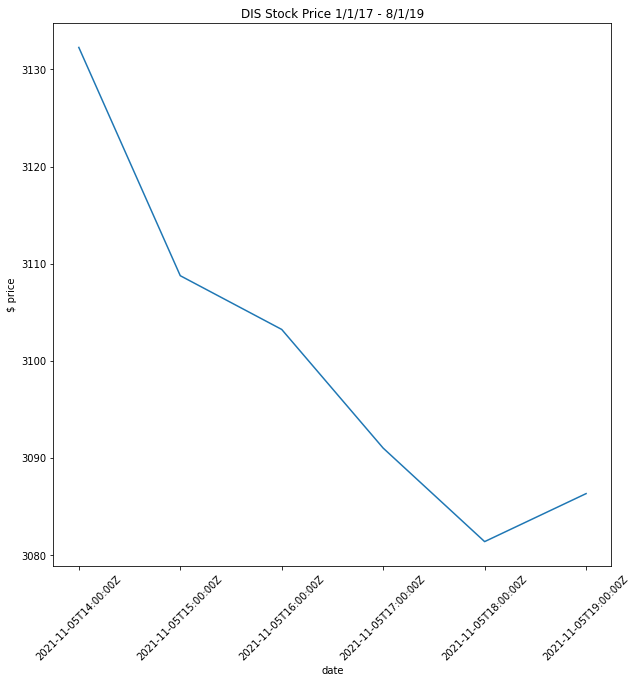

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(tt.index, tt['contribution'])
plt.xlabel("date")
plt.xticks(rotation = 45) 
plt.ylabel("$ price")
plt.title("DIS Stock Price 1/1/17 - 8/1/19")

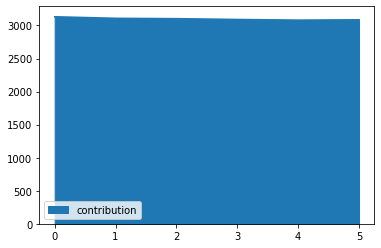

In [ ]:
area_chart = px.area(tt, title = 'TOTAL PORTFOLIO DAILY')
area_chart.update_xaxes(title_text = 'Date')
area_chart.update_yaxes(title_text = 'Total', tickprefix = '$')
area_chart.update_layout(showlegend = False)

tt.plot.area()

In [ ]:
tt.groupby(by=["symbol"]).sum()

In [ ]:
rh.robinhood.stocks.get_fundamentals("TSLA")

[{'average_volume': '38553696.636364',
  'average_volume_2_weeks': '38553696.636364',
  'ceo': 'Elon Reeve Musk',
  'description': 'Tesla, Inc. engages in the design, development, manufacture, and sale of fully electric vehicles, energy generation and storage systems. It also provides vehicle service centers, supercharger station, and self-driving capability. The company operates through the following segments: Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture and sale of electric vehicles. The Energy Generation and Storage segment includes the design, manufacture, installation, sale, and lease of stationary energy storage products and solar energy systems, and sale of electricity generated by its solar energy systems to customers. It develops energy storage products for use in homes, commercial facilities and utility sites. The company was founded by Jeffrey B. Straubel, Elon Reeve Musk, Martin Eberhard, and Marc Tarpenn

In [ ]:
rh.robinhood.authentication.logout()

|

|

|

|

|

In [2]:
import pandas as pd
import sqlite3
russel_df = pd.read_csv("/content/Stocks in the Russell 1000 Index.csv")

In [3]:
russel_df

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Country,Action
0,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$2,495,877,938,999",0.67%,USA,Analyze
1,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,426,013,924,390",0.58%,USA,Analyze
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,981,599,901,640",0.00%,USA,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,981,599,901,640",0.00%,USA,Analyze
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$1,761,070,110,450",0.00%,USA,Analyze
...,...,...,...,...,...,...,...,...,...
1020,SLVM,Sylvamo Corporation,Common stocks,Small cap,Materials,"$1,324,539,264",0.00%,USA,Analyze
1021,UWMC,UWM Holdings Corporation Class A,Common stocks,Small cap,Financials,"$699,561,322",4.25%,USA,Analyze
1022,PSFE,Paysafe Limited,Common stocks,Small cap,Information Technology,"$622,022,183",0.00%,Bermuda,Analyze
1023,GOCO,"GoHealth, Inc. - Class A",Common stocks,Small cap,Financials,"$515,829,416",0.00%,USA,Analyze


In [7]:
import json
try:
    # For Python 3.0 and later
        from urllib.request import urlopen
except ImportError:
# Fall back to Python 2's urllib2
    from urllib2 import urlopen

In [5]:
def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.
    """
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

In [ ]:
dd = pd.DataFrame()
apiKey = ['49dddabbcf6a628339fbc25049270225', '813841e1635f4f74e3555996113e7470',
          '81c66b2b7a409dde0ec114b052cd0d45', '1817f0b75f62e8d3556c787b8e58a6a8',
          'a4bedca2df6809daa70d74cf9671699f']

count = 0
for ticker in russel_df['Symbol']:
  i = count //210
  url = f"https://financialmodelingprep.com/api/v3/profile/{ticker}?apikey={apiKey[i]}"
  try:
    dd = dd.append(pd.DataFrame(get_jsonparsed_data(url)[0], index=[0])[['symbol', 'cusip']])
  except Exception as e:
    # print(e, ticker)
    print("e")
  count+=1

dd

In [ ]:
dd=dd.dropna()

In [ ]:
dd.to_csv("try.csv")

\
ᴬᴬ

ᴬ


In [ ]:
import pandas as pd
import sqlite3
all_comps_df = pd.read_csv("/content/try.csv").drop(columns='Unnamed: 0')

In [ ]:
dd = pd.DataFrame()
apiKey = ['49dddabbcf6a628339fbc25049270225', '813841e1635f4f74e3555996113e7470',
          '81c66b2b7a409dde0ec114b052cd0d45', '1817f0b75f62e8d3556c787b8e58a6a8',
          'a4bedca2df6809daa70d74cf9671699f']

count = 0
for ticker in all_comps_df['symbol']:
  i = count //210
  url = f"https://financialmodelingprep.com/api/v3/market-capitalization/{ticker}?apikey={apiKey[i]}"
  try:
    dd = dd.append(pd.DataFrame(get_jsonparsed_data(url)[0], index=[0])[['symbol', 'marketCap']])
  except Exception as e:
    print(e, ticker)
  count+=1

dd

In [ ]:
dd.to_csv("market_cap.csv")

In [ ]:
all_comps_df

In [ ]:
dd = pd.DataFrame()
apiKey = ['49dddabbcf6a628339fbc25049270225', '813841e1635f4f74e3555996113e7470',
          '81c66b2b7a409dde0ec114b052cd0d45', '1817f0b75f62e8d3556c787b8e58a6a8',
          'a4bedca2df6809daa70d74cf9671699f']

count = 0
for ticker in all_comps_df['symbol']:
  i = count //210
  
  url = f"https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?limit=120&apikey={apiKey[i]}"
  try:
    dd = dd.append(pd.DataFrame(get_jsonparsed_data(url)[0], index=[0])[['symbol', 'operatingCashFlow']])
  except Exception as e:
    print(e, ticker)
  count+=1

dd